
# Dont touch your face using CNN: 4 convolutional layer and 1 fully connected layer


### Dataset: Collected from students in ML-DL class

- Consist of 224x224 pixels RGB scales images belong to 3 class: Touch, No hands, No Touch w hands
- size: ~ 40k images
- 80% of images are insided the train folder and 20% are insided the validation folder

### Access the directory

In [1]:
import os

train_data_dir = 'images/train'
validation_data_dir = 'images/validation/'

# print all subjects in the train directory
subjects_in_train = os.listdir(train_data_dir)
print(subjects_in_train)  


['Class 3 No Touch w Hands', 'Class 1 Touch', 'Class 2 No hands']


### Loading and Exploring the dataset

In [2]:
import cv2
# Function to load the image
def load_image(directory):
    images_path = []
    labels = []
    # access into each label folder and image inside that label
    for images_class in os.listdir(directory):
        for image_file in os.listdir(os.path.join(directory, images_class)):
            image_path = os.path.join(directory, images_class, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images_path.append(image)
            labels.append(images_class)
    return images_path, labels


# Load images and labels from train and validation directories
train_images, train_labels = load_image(train_data_dir)
print("Train Image: ", len(train_images), "Labels: ", len(train_labels))
validation_images, validation_labels = load_image(validation_data_dir)
print("Validate Image: ", len(validation_images), "Labels: ", len(validation_labels))


Train Image:  15616 Labels:  15616
Validate Image:  3479 Labels:  3479


### Channel is 3 for color images: RGB

In [3]:
import pandas as pd

train = pd.DataFrame()
train['image'], train['label'] = load_image(train_data_dir)      # call the load_image function on train folder
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train

,image,label
0,"[[[177, 177, 177], [177, 177, 177], [178, 178,...",Class 3 No Touch w Hands
1,"[[[218, 211, 205], [219, 212, 206], [217, 212,...",Class 2 No hands
2,"[[[121, 119, 106], [122, 120, 107], [124, 122,...",Class 1 Touch
3,"[[[228, 214, 188], [227, 213, 187], [227, 212,...",Class 2 No hands
4,"[[[111, 111, 99], [111, 111, 99], [112, 112, 1...",Class 3 No Touch w Hands
...,...,...
15611,"[[[248, 244, 235], [249, 245, 236], [249, 245,...",Class 2 No hands
15612,"[[[76, 80, 83], [77, 81, 84], [77, 81, 84], [7...",Class 2 No hands
15613,"[[[157, 147, 138], [158, 148, 139], [158, 149,...",Class 1 Touch
15614,"[[[219, 214, 208], [219, 214, 208], [219, 214,...",Class 2 No hands


### Visualize a few sample images from training set


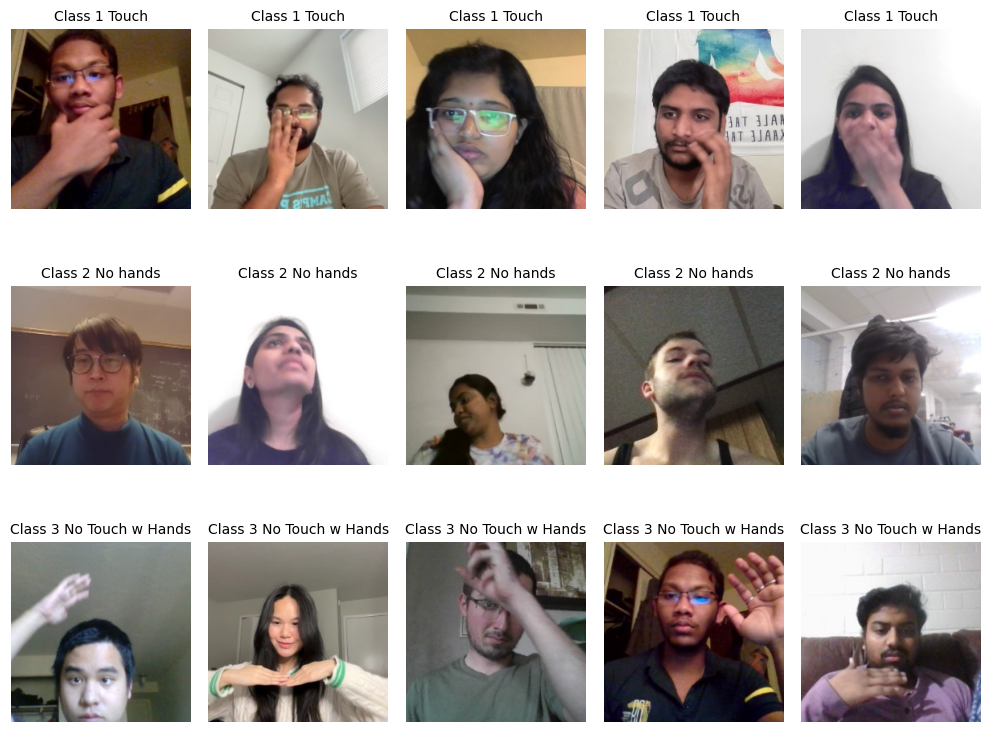

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(images, labels, num_samples):
    # Get unique labels and initialize the plot counter
    class_names = np.unique(labels)
    plot_count = 1
    
    # Determine the total number of plot rows needed
    num_classes = len(class_names)
    fig = plt.figure(figsize=(10, 8))
    
    for class_name in class_names:
        # Find indices of images belonging to the current class
        class_indices = np.where(labels == class_name)[0][:num_samples]
        for idx in class_indices:
            # Create a subplot for each sample image
            ax = fig.add_subplot(num_classes, num_samples, plot_count)
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')  # Hide axes ticks
            ax.set_title(class_name, fontsize=10)
            plot_count += 1

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.0, wspace=0.1)  # Adjust the space between plots
    plt.show()

# function call
plot_sample_images(train['image'], train['label'], num_samples=5)


### Plotting the training set distribution

python(42279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


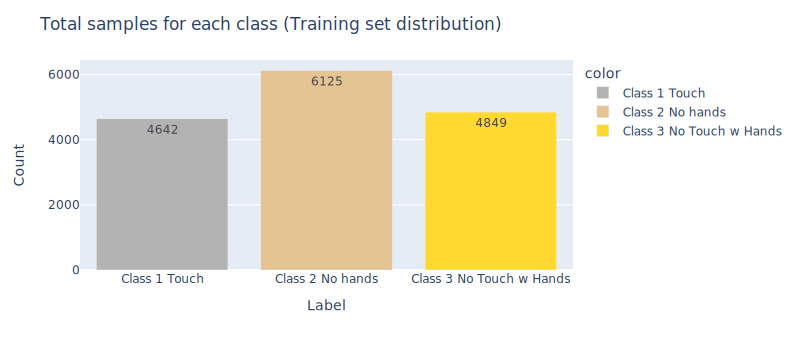

In [4]:
import plotly.express as px
import plotly.io as pio
import numpy as np

pio.renderers
# Calculate the count of images for each class in the training set
train_class_counts = {class_name: np.sum(train['label'] == class_name) for class_name in np.unique(train['label'])}

# Create a bar chart using a custom color sequence
fig = px.bar(
    x=list(train_class_counts.keys()),
    y=list(train_class_counts.values()),
    color=list(train_class_counts.keys()),
    color_discrete_sequence=px.colors.qualitative.Set2_r
)
fig.update_layout(
    title="Total samples for each class (Training set distribution)",
    xaxis_title="Label",
    yaxis_title="Count",
    width=800,
    height=350
)
fig.update_traces(texttemplate='%{y}', textposition='inside')  # Display count labels on the bars
fig.show(renderer="svg")


### Create class to handle accessing images for training or evaluation better for DL workflow


In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder

# image augmentation, transform on RGB, and convert to tensor

train_transforms = transforms.Compose([
    transforms.CenterCrop(224), # to focus on center
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), #images shift along 10% x/y axis
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.4, hue=0.05),
    transforms.RandomRotation(20),  # Randomly rotate the image by 20 degrees
    transforms.ToTensor(),  # Converts the PIL Image (HxWxC) in the range [0, 255] to a tensor shape (CxHxW) in the range [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # derived these number from the ImageNet on RGB channel
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Processing to tensor and aumenting images for pretrained model
- randomly transform, flip, rotate to increase the diversity
- convert to tensor
- normalize dataset
- Changle color with brightness, contrast, saturation and hue

### Load dataset to loader and set batch size to 32

In [5]:

# apply transform on dataset
train_set = ImageFolder(root=train_data_dir, transform=train_transforms)
validation_set = ImageFolder(root=validation_data_dir, transform=val_transforms)


# load data to loader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False)    

# check the size after transfer to loader for Torch
print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(validation_set)}")

# Check the shape of the first training image [channel, width, height]
train_x, train_y = train_set[0]
print(f"Shape of first training images in first batch : {train_x.shape}")
print(f"first label images : {train_y}")


for batch in train_loader:
    images, labels = batch
    print(f"Shape of first training images in first batch: {images.shape}")  # [batch_size, channels, height, width]
    print(f"Check type of input and label", type(images), type(images))
    break  

Number of training samples: 34107
Number of validation samples: 5318
Shape of first training images in first batch : torch.Size([3, 224, 224])
first label images : 0
Shape of first training images in first batch: torch.Size([32])
Check type of input and label <class 'torch.Tensor'> <class 'torch.Tensor'>


## CNN model
### Bulding Deep Learning model with 4-layer of convolutional neural network and 1 fully connected layer

In [6]:
# mport pytorch library and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.optim import Adam
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, BatchNorm2d, BatchNorm1d, Dropout, AdaptiveAvgPool2d

### Architecture of Deep CNN model
- 4 convolutional layes to extract features from images with 32 3x3 filters, 64 3x3 filters, 128 3x3 filters, 512 3x3 filters 
    - Each convolutional layer: stride 1, batch normalization, dropout rate 0.1, max-pooling and ReLU
- flattening step
- Average global pooling
- 1 fully connected dense layers 
    - 256 neuron in the input layers and 512 neuron of in hidden layers
    - batch norm, dropout, ReLu on each layer

- Channel for Convolutional layer should be 3 because this is color image 

In [15]:
class convnet(nn.Module):
    # constructor initialize instances of class
    def __init__(self, num_classes):
        super(convnet, self).__init__()         # Call the init method of nn.Module

        # defining 2D convolutional layers by Squential for cleaner look
        self.cnn_layers = Sequential(
            # stride=1 paddind = 0 by default
            # first block:
            Conv2d(3, 32, kernel_size = 3, padding = 1),  # dot product of input and kernel to complete 1 pixel at a time: stride
            BatchNorm2d(32),                                        # improves the performance and stability of NNs with unit
            ReLU(),                                                 # non linear func to squash linear combination into 0 and 1
            # Dropout(p=0.25),                                         # reduces overfitting/prevent not relying on one node in the layer too much
            # MaxPool2d(kernel_size=2),                               # reduce dimension but still obtain important data

            # second block
            Conv2d(32, 64, kernel_size = 3, padding = 1),            
            BatchNorm2d(64), 
            ReLU(),
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2),
            
            # third block
            Conv2d(64, 128, kernel_size = 3, padding = 1),           
            BatchNorm2d(128), 
            ReLU(),                                                
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2),

            # fourth block
            Conv2d(128, 256, kernel_size = 3, padding = 1),          
            BatchNorm2d(256), 
            ReLU(),
            Dropout(p=0.25),
            MaxPool2d(kernel_size=2),
        )

        # Global Average Pooling: help the output of the GAP layer to a 1D
        self.global_avg_pool = AdaptiveAvgPool2d((1, 1))

        # definind 2 fully connected layer (multi layers nn)
        self.linear_layers = Sequential(
            # 256 neuron of first hidden layers and 512 neuron of second hidden layers

            # first fully connected layer  (input to hidden1)
            Linear(256, 512),       # input size of flatten layer: 256 with 512 hidden node in first hidden layer
            BatchNorm1d(512),
            ReLU(),
            Dropout(p=0.25),

            # hidden to output
            Linear(512, num_classes)
        )
    
    def forward(self, x):
        # forward pass through cnn and linear layers
        z1 = self.cnn_layers(x)  

        # Adding Global Average Pooling
        z1 = self.global_avg_pool(z1)
        z1 = z1.view(z1.size(0), -1)  # Flatten the output of conv layers       
        # output flatten of convo layer is input of fully connected layer
        z2 = self.linear_layers(z1) 
        
        # return F.softmax(z2, dim = 1) 
        return z2

### debug to check the size of output of flatten layer before feed in FC layers
- if using AdaptiveAvgPool, dont need to adjust the input size for the first fully connected layer bc it flatten the tensor to 1D for each vector of size 512 for each image in the batch

In [16]:
model = convnet(num_classes=3)  # instantiate the instance of class 

# Create input with the size of input images (batch_size, channels, height, width)
check_input = torch.randn(1, 3, 224, 224)

check_input = model.cnn_layers(check_input)
# Print the resulting size
print(check_input.size())

torch.Size([1, 256, 27, 27])


### define the opmizier and loss function for model

- For objective function in supervise learning task: goal is to minimize this function (distance between predict and actual)
    - Loss function: using cross entropy because this is classification problems
    - Optimization: Using Adam with learning rate at 0.001, weight regulation at 1e-7

In [17]:
# Instantiate the model
num_classes = 3
model = convnet(num_classes)

# defining the optimizer: Adam with regulation to prevent overfitting
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay=1e-7)     
# defining the loss function
criterion = CrossEntropyLoss()
print(model)


convnet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [18]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)
model = model.to(device)

mps


In [19]:

def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = 0
    total_samples = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # No track gradients
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred = torch.argmax(outputs, dim=1)                   # Use argmax to get predictions: highest prob

            # accuracy metric as the number of correctly predicted results / total numbe of samples
            predictions += torch.sum(y_pred == labels).item()
            total_samples += labels.size(0)                         # length of tensor at first dimension

            # store for confusion matrix from scikit-learn in numpy form. CPU for comparable with library scikit-learn
            pred_labels.extend(y_pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    total_acc = predictions / total_samples
    # print(f'Accuracy: {total_acc:.2f}')
    
    return total_acc, true_labels, pred_labels

### Training and Evaluate the model on both validation

In [20]:
def fit(epochs):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    # for saving the best value of each epoch
    best_val_loss = float('inf')
    
    for epoch in range(epochs):

        # -------- Calculate training acc for the previous epoch--------
        train_accuracy, _, _ = calculate_accuracy(model, train_loader)
        train_acc.append(train_accuracy)

        # --------Training loss--------
        tr_loss = 0
        # set model in training mode
        model.train()
        for inputs, labels in train_loader:
            # load dataset to device
            inputs, labels = inputs.to(device), labels.to(device)

            # clear the gradient of model parameters
            optimizer.zero_grad()

            # Forward pass: prediction for training and validation set from the input
            train_output = model(inputs)                            # output from predict on training set
            train_loss = criterion(train_output, labels)            # calculate the loss between output and ground truth with cross entropy

            # Backward pass and optimize: to updated the weight of all model parameters to improve the loss
            train_loss.backward()                                   # backpropagate
            optimizer.step()                                        # gradient decent to update paramter
            tr_loss += train_loss.item()                            # extract and keep track loss each epochs: .item(): is single-element tensor convert to float format

        avg_train_loss = tr_loss/ len(train_loader)                 # divide accumulated loss by the number of batches 
        train_losses.append(avg_train_loss)

        
        # --------Validation loss--------
        validate_loss = 0
        model.eval()
        with torch.no_grad():                                       # no gradient on validation
            for inputs, labels in val_loader:
                # load dataset to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass on validation. No backward on validation
                val_output = model(inputs)                                 
                val_loss = criterion(val_output, labels)            
                validate_loss += val_loss.item()                            # keep track of loss each epochs
            
            avg_val_loss = validate_loss/len(val_loader)  

            # Check if this is the best model so far
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict() # save the best model state
                torch.save(model.state_dict(), 'best_model_state1.pth')
            val_losses.append(avg_val_loss)                                 # store best loss value

        # Calculate validation accuracy each epoch
        val_accuracy, _, _ = calculate_accuracy(model, val_loader)
        val_acc.append(val_accuracy)

        # if epoch % 2 == 0:
        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}  ')

    return train_losses, val_losses, train_acc, val_acc, best_model_state

In [21]:
num_epochs = 20
train_loss, val_loss, train_acc, val_acc, best_model_state = fit(num_epochs)

Epoch 1/20 | Train Loss: 1.1416 | Val Loss: 1.1086 | Train Acc: 0.3424 | Val Acc: 0.3123  
Epoch 2/20 | Train Loss: 1.0903 | Val Loss: 1.1016 | Train Acc: 0.3594 | Val Acc: 0.3473  
Epoch 3/20 | Train Loss: 1.0858 | Val Loss: 1.1049 | Train Acc: 0.3617 | Val Acc: 0.3593  
Epoch 4/20 | Train Loss: 1.0676 | Val Loss: 1.0969 | Train Acc: 0.3792 | Val Acc: 0.3757  
Epoch 5/20 | Train Loss: 1.0304 | Val Loss: 1.0262 | Train Acc: 0.3881 | Val Acc: 0.4376  
Epoch 6/20 | Train Loss: 0.9725 | Val Loss: 1.1480 | Train Acc: 0.4423 | Val Acc: 0.4020  
Epoch 7/20 | Train Loss: 0.9104 | Val Loss: 1.0635 | Train Acc: 0.3875 | Val Acc: 0.4428  
Epoch 8/20 | Train Loss: 0.8349 | Val Loss: 0.9738 | Train Acc: 0.4889 | Val Acc: 0.4883  
Epoch 9/20 | Train Loss: 0.7656 | Val Loss: 1.0297 | Train Acc: 0.5197 | Val Acc: 0.4983  
Epoch 10/20 | Train Loss: 0.7040 | Val Loss: 1.0900 | Train Acc: 0.5751 | Val Acc: 0.4752  
Epoch 11/20 | Train Loss: 0.6420 | Val Loss: 1.0976 | Train Acc: 0.5848 | Val Acc: 0.5149

### The the loss curve of train/validation

In [22]:
import plotly.graph_objects as graph
# pio.renderers

fig = graph.Figure()

# the training loss 
fig.add_trace(graph.Scatter(y=train_loss, mode='lines', name='Training Loss'))
# the validation loss 
fig.add_trace(graph.Scatter(y=val_loss, mode='lines', name='Validation Loss'))
# Update the layout with titles and axis labels
fig.update_layout(title='Training and Validation Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss',
                  width=900,
                  height=400)

fig.show()

In [24]:
fig = graph.Figure()

# the training loss 
fig.add_trace(graph.Scatter(y=train_acc, mode='lines', name='Training Accuracy'))
# the validation loss 
fig.add_trace(graph.Scatter(y=val_acc, mode='lines', name='Validation Accuracy'))
# Update the layout with titles and axis labels
fig.update_layout(title='Training and Validation Accuracy over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  width=900,
                  height=400)
fig.show()

In [25]:
train_accuracy, train_true_labels, train_pred_labels = calculate_accuracy(model, train_loader)
val_accuracy, val_true_labels, val_pred_labels = calculate_accuracy(model, val_loader)


print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Train Accuracy: 0.6999
Validation Accuracy: 0.4577


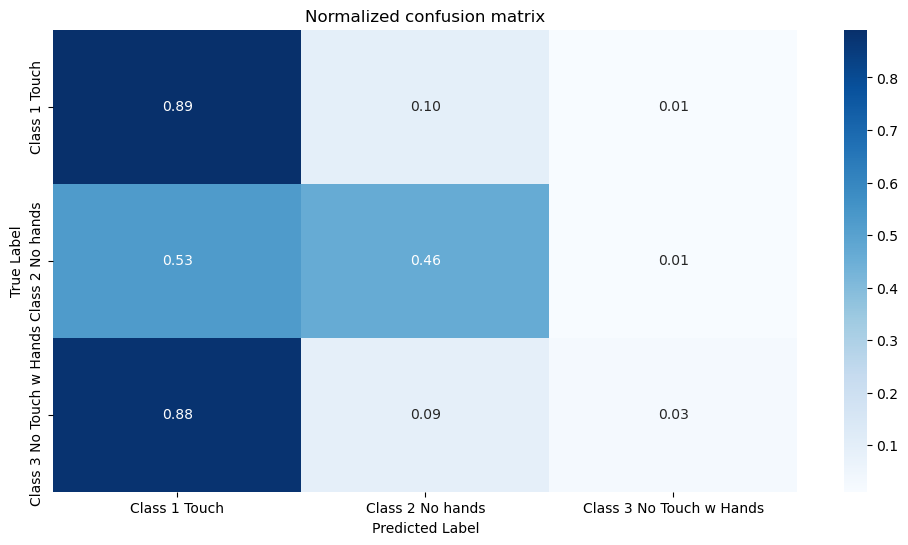

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


class_names = np.unique(train['label'])

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with class names
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", fmt=".2f", cbar=True, 
            xticklabels=class_names, yticklabels=class_names)

plt.title("Normalized confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()